<a href="https://colab.research.google.com/github/scriptWhiz/TESTINGFORRASH-/blob/main/POWER_NETWORK_FLOW_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from dataclasses import dataclass
import pyomo.environ as pyo


PCC_BUS_INDEX = 1
PCC_CAPACITY = 0
PCC_IMP_COST = 50
PCC_EXP_COST = 5
SCALE_RATING = 1.2e-3
@dataclass
class Generator:
    P: float
    Pmin: float
    Pmax: float
    c1: float
    c2: float
    c3: float

G = nx.DiGraph()


G.add_node(1, P=0.0,  pos=(1, 3))
G.add_node(2, P=0.0,  pos=(0.7, 2))
G.add_node(3, P=0,  pos=(0.6, 0.2))
G.add_node(4, P=0.07, pos=(1.2, 0))
G.add_node(5, P=0.07, pos=(1.5, 1.8))

# Add the lines
# From bus, to bus, r (resistance in Ohm), rating (power rating in base units)
G.add_edge(1, 2, rating=40*SCALE_RATING, closed=True)
G.add_edge(1, 4, rating=60*SCALE_RATING, closed=True)
G.add_edge(1, 5, rating=40*SCALE_RATING, closed=True)
G.add_edge(2, 3, rating=40*SCALE_RATING, closed=True)
G.add_edge(2, 4, rating=60*SCALE_RATING, closed=True)
G.add_edge(2, 5, rating=30*SCALE_RATING, closed=True)
G.add_edge(3, 4, rating=70*SCALE_RATING, closed=True)
G.add_edge(4, 5, rating=70*SCALE_RATING, closed=True)

# Generators
generators = {2: Generator(P=50, Pmin=0.05, Pmax=0.15, c1=200, c2=60, c3=0.00889)}

def plot():
  pos = nx.get_node_attributes(G, 'pos')
  nx.draw(G, pos, with_labels=True,alpha=0.5,linewidths=0.5)  # DEBUG
  plt.show()  # DEBUG

def solve(m: pyo.ConcreteModel, solver_name: str):
    t0 = time.time()
    solver = pyo.SolverFactory(solver_name, executable=f"/content/ampl.linux-intel64/{solver_name}")
    results = solver.solve(m, tee=False)

    if not pyo.check_optimal_termination(results):
        print("Solution not optimal. Exiting")
        print(results.solver.termination_condition)
        filename = 'model-%s.lp' % time.time()
        m.write(filename, io_options={'symbolic_solver_labels': True})

        return -1

    print('Solution time = %s' % (time.time()-t0))
    return 0

def show_solution(m: pyo.ConcreteModel, squared_voltages=False):
  """
  Show a solution once the problem is solved
  """
  print("Cost = ", m.cost())

  for b in m.generators:
      print("Power generated at bus %d = %g" %
            (b, m.p_generated[b].value))


  labels = {(f, t): "%.2f" % (1e3*m.p_line[f, t].value) for (f, t) in m.lines}
  pos = nx.get_node_attributes(G, 'pos')
  nx.draw(G, pos, with_labels=True,alpha=0.5,linewidths=0.5)  # DEBUG
  nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
  plt.show()  # DEBUG

def generation_cost(m: pyo.ConcreteModel, b: int):
  """
  b is a generator index
  """
  g = generators[b]
  return (g.c1 + g.c2 * m.p_generated[b] + g.c3 * (m.p_generated[b])**2)

def pcc_costfunction (m: pyo.ConcreteModel):
  return(m.PCC_PowerImported*PCC_IMP_COST-m.PCC_PowerExported*PCC_EXP_COST)


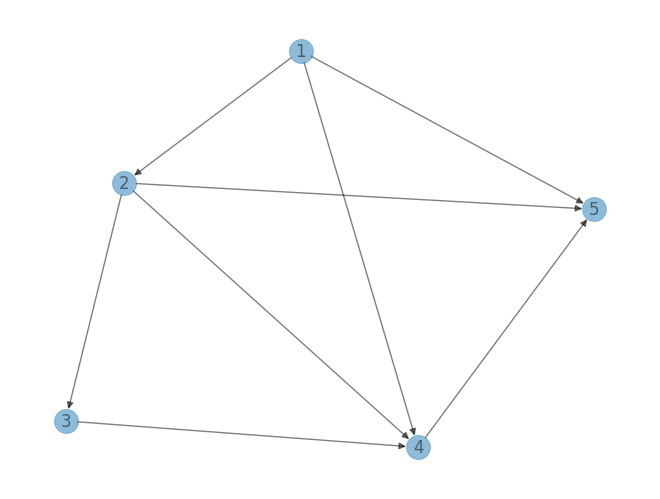

In [ ]:
plot()

In [ ]:
!pip install pyomo.extras

ERROR: Could not find a version that satisfies the requirement pyomo.extras (from versions: none)
ERROR: No matching distribution found for pyomo.extras


In [ ]:
 !apt install -y coinor-cbc coinor-ipopt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package coinor-ipopt


In [ ]:

# Create a Pyomo model that will contain all sets, variables, constraints, objective.
m = pyo.ConcreteModel()

# SETS
# All buses
m.buses = pyo.Set(initialize=[b for b in G.nodes()])
# subset of buses with generators
m.generators = pyo.Set(initialize=generators.keys())
# All edges
m.lines = pyo.Set(initialize=[e for e in G.edges()])

# VARIABLES
m.p_line = pyo.Var(m.lines, domain=pyo.Reals, initialize= 0)
m.p_generated = pyo.Var(m.generators, domain=pyo.NonNegativeReals , initialize= 0)
m.PCC_PowerExported = pyo.Var(domain=pyo.NonNegativeReals, initialize= 0)
m.PCC_PowerImported = pyo.Var(domain=pyo.NonNegativeReals, initialize= 0)
m.PCC_Cap=pyo.Var(domain=pyo.Reals, initialize=0)

# CONSTRAINTS
#constraint for LINES the amount flowing through the line should be dependent on the rating + or -
m.p_line_constraints = pyo.ConstraintList() #Hint you can create a list of constraints and add constraints one by one:
for (f, t) in m.lines:
  m.p_line_constraints.add(m.p_line[f, t] <= G[f][t]['rating'])
  m.p_line_constraints.add(m.p_line[f, t] >= -G[f][t]['rating'])


#constraint on Power balances coming into the bus=Power leaving the bus
#defining the BUSES
m.power_balance = pyo.ConstraintList()
for b in m.buses:
  if b in m.generators:
   expr = m.p_generated[b]
  elif b== PCC_BUS_INDEX:
   expr = m.PCC_PowerImported - m.PCC_PowerExported
  else:
   expr = -G.nodes[b]['P']

#the actual constraint power conservation of lines
  for (f, t) in G.in_edges(b):
    expr += m.p_line[f,t]
  for (f, t) in G.out_edges(b):
    expr -= m.p_line[f,t]

 #To ensure balanced network
  m.power_balance.add(expr == 0)

#constraint for GENERATOR: pmin>= power generated <=pmax
m.generator_constraints= pyo.ConstraintList()
for b in m.generators:
  m.generator_constraints.add(m.p_generated[b]<= generators[b].Pmax)
  m.generator_constraints.add(m.p_generated[b]>= generators[b].Pmin)


# constraint on PCC
m.PCC_Cap_constraints= pyo.ConstraintList ()
m.PCC_Cap_constraints.add(m.PCC_Cap <= +PCC_CAPACITY )
m.PCC_Cap_constraints.add(m.PCC_Cap >= -PCC_CAPACITY )
m.PCC_Cap_constraints.add(m.PCC_Cap == m.PCC_PowerImported-m.PCC_PowerExported)


# Objective
m.cost = pyo.Objective(sense= pyo.minimize, expr=sum(generation_cost(m,b) for b in m.generators) + pcc_costfunction(m))# TODO Objective

solve(m, 'ipopt')
show_solution(m)
print(G.nodes[2]['P'])

Failed to set executable for solver ipopt. File with name=/content/ampl.linux-intel64/ipopt either does not exist or it is not executable. To skip this validation, call set_executable with validate=False.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pyomo/opt/base/solvers.py", line 148, in __call__
    opt = self._cls[_name](**kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pyomo/solvers/plugins/solvers/IPOPT.py", line 44, in __init__
    super(IPOPT, self).__init__(**kwds)
  File "/usr/local/lib/python3.11/dist-packages/pyomo/opt/solver/shellcmd.py", line 66, in __init__
    self.set_executable(name=executable, validate=validate)
  File "/usr/local/lib/python3.11/dist-packages/pyomo/opt/solver/shellcmd.py", line 115, in set_executable
    raise ValueError(
ValueError: Failed to set executable for solver ipopt. File with name=/content/ampl.linux-intel64/ipopt either does not exist or it is not executable. To

RuntimeError: Attempting to use an unavailable solver.

The SolverFactory was unable to create the solver "ipopt"
and returned an UnknownSolver object.  This error is raised at the point
where the UnknownSolver object was used as if it were valid (by calling
method "solve").

The original solver was created with the following parameters:
	executable: /content/ampl.linux-intel64/ipopt
	type: ipopt
	_args: ()
	options: {}